Aim: predict efficiency of the entire cell using the device stack including the CTL names.

Using the CrabNet notebook with which Pepe predicted bandgap (sent via Discord)
The code here is an adapted selection of that.

In [3]:
#from crabnet.crabnet_ import CrabNet
from matplotlib import pyplot as plt
import numpy as np
import requests
import pandas as pd

Get the cells with relevant properties (cells that have a PCE reported)

In [8]:
base_url = 'https://nomad-lab.eu/prod/v1/api/v1/'

def extract_values(entry):
    try:
       bandgaps.append(entry['results']['properties']['electronic']['band_structure_electronic'][0]['band_gap'][0]['value'])
    except:
       bandgaps.append('None')
    try:
      reduced_formulas.append(entry['results']['material']['chemical_formula_reduced'])
      iupac_formulas.append(entry['results']['material']['chemical_formula_iupac'])
      descriptive_formulas.append(entry['results']['material']['chemical_formula_descriptive'])
    except:
      reduced_formulas.append('None')
      iupac_formulas.append('None')
      descriptive_formulas.append('None')
    try:
      vocs.append(entry['results']['properties']['optoelectronic']['solar_cell']['open_circuit_voltage'])	
    except:
      vocs.append('None')
    try:
      jscs.append(entry['results']['properties']['optoelectronic']['solar_cell']['short_circuit_current_density'])
    except:
      jscs.append('None')
    try:
      ffs.append(entry['results']['properties']['optoelectronic']['solar_cell']['fill_factor'])
    except:
      ffs.append('None')
    try:
      pces.append(entry['results']['properties']['optoelectronic']['solar_cell']['efficiency'])
    except:
      pces.append('None')
    try:
      device_stack.append(entry['results']['properties']['optoelectronic']['solar_cell']['device_stack'])
    except:
      device_stack.append('None')
    try:
      htl.append(entry['results']['properties']['optoelectronic']['solar_cell']['hole_transport_layer'])
    except:
      htl.append('None')
    try:
      etl.append(entry['results']['properties']['optoelectronic']['solar_cell']['electron_transport_layer'])
    except:
      etl.append('None')
    try:
      structural_dimensionality.append(entry['results']['material']['structural_type'])
    except:
      structural_dimensionality.append('None')
    return bandgaps, reduced_formulas, iupac_formulas, descriptive_formulas, vocs, jscs, ffs, pces, device_stack, htl, etl, structural_dimensionality

bandgaps =[]
vocs = []
jscs = []
ffs = []
pces = []
reduced_formulas = []
iupac_formulas = []
descriptive_formulas = []
htl = []
etl = []
device_stack = []
structural_dimensionality = []
page_after_value = None

while True:
    data = requests.post(f'{base_url}entries/query', json={
        "owner": "visible",
        "aggregations": {},
        "query": {
            "and": [
                {"results.material.elements:all": ["Sn"]},
                {"sections:all": ["nomad.datamodel.results.SolarCell"]},
                ]},
        "required": {
            "results":{
                "material": {
                    "chemical_formula_reduced":"*",
                    "structural_type":"*"},
                "properties": {
                   "optoelectronic":{
                      "band_gap":"*",
                      "solar_cell":{
                          "open_circuit_voltage":"*",
                          "short_circuit_current_density":"*",
                          "fill_factor":"*",
                          "efficiency":"*",
                          }}},},
        },
        "pagination": {"page_size": 10,
                       "page_after_value": page_after_value}
        }).json()


    if not data['data']:
      break
    if 'next_page_after_value' not in data['pagination'].keys():
    # make sure to grasp the entries of the last page before breaking
      for entry in data['data']:
          if 'results' not in entry.keys():
              continue
          elif 'chemical_formula_reduced' not in entry['results']['material'].keys():
              continue
          else:
              extract_values(entry)
      break
    page_after_value = data['pagination']['next_page_after_value']

    for entry in data['data']:
        if 'results' not in entry.keys():
            continue
        elif 'chemical_formula_reduced' not in entry['results']['material'].keys():
            continue
        else:
            extract_values(entry)

In [13]:
df = pd.DataFrame({
    'reduced_formulas': reduced_formulas,
    'iupac_formulas': iupac_formulas,
    'descriptive_formulas': descriptive_formulas,
    'bandgap': bandgaps,
    'voc': vocs,
    'jsc': jscs,
    'ff': ffs,
    'pce': pces,
    'device_stack': device_stack,
    'htl': htl,
    'etl': etl,
    'structural_dimensionality': structural_dimensionality
    })


In [16]:
df.to_csv('pickles/df_Sn_many_properties.csv', index=False)

In [4]:
# if necessary, load from here
df = pd.read_csv('pickles/df_Sn_many_properties.csv')
df.head()

,reduced_formulas,iupac_formulas,descriptive_formulas,bandgap,voc,jsc,ff,pce,device_stack,htl,etl,structural_dimensionality
0,Br36C20H120I24N20Pb15Sn5,Pb15Sn5C20N20H120I24Br36,MAPb0.75Sn0.25Br1.8I1.2,2.771766e-19,0.990,151.6,0.740,11.11,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'bis-C60']",bulk
1,CH5I3N2Sn,SnCN2H5I3,FASnI3,NaN,0.632,203.7,0.693,8.62,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",bulk
2,CsI3Sn,CsSnI3,CsSnI3,NaN,0.350,84.4,0.490,1.46,"['SLG', 'ITO', 'Perovskite', 'PCBM-60', 'BCP',...",['none'],"['PCBM-60', 'BCP']",bulk
3,C6H18I6S2Sn,SnC6H18S2I6,((CH3)3S)2SnI6,NaN,0.490,43.4,0.530,1.12,"['SLG', 'FTO', 'TiO2-mp', 'D35', 'Perovskite',...",['none'],"['TiO2-mp', 'D35']",2D
4,C2H12I6N2PbSn,PbSnC2N2H12I6,MAPb0.5Sn0.5I3,NaN,0.660,233.0,0.671,10.30,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'Phen-NaDPO']",bulk


In [5]:
# Change the values of bandgap from units of Joule to electronvolt
df['bandgap'] = pd.to_numeric(df['bandgap'], errors='coerce')
df['bandgap'] = df['bandgap']*6.24150974e18
df

,reduced_formulas,iupac_formulas,descriptive_formulas,bandgap,voc,jsc,ff,pce,device_stack,htl,etl,structural_dimensionality
0,Br36C20H120I24N20Pb15Sn5,Pb15Sn5C20N20H120I24Br36,MAPb0.75Sn0.25Br1.8I1.2,1.73,0.990,151.6,0.740,11.11,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'bis-C60']",bulk
1,CH5I3N2Sn,SnCN2H5I3,FASnI3,NaN,0.632,203.7,0.693,8.62,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",bulk
2,CsI3Sn,CsSnI3,CsSnI3,NaN,0.350,84.4,0.490,1.46,"['SLG', 'ITO', 'Perovskite', 'PCBM-60', 'BCP',...",['none'],"['PCBM-60', 'BCP']",bulk
3,C6H18I6S2Sn,SnC6H18S2I6,((CH3)3S)2SnI6,NaN,0.490,43.4,0.530,1.12,"['SLG', 'FTO', 'TiO2-mp', 'D35', 'Perovskite',...",['none'],"['TiO2-mp', 'D35']",2D
4,C2H12I6N2PbSn,PbSnC2N2H12I6,MAPb0.5Sn0.5I3,NaN,0.660,233.0,0.671,10.30,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'Phen-NaDPO']",bulk
...,...,...,...,...,...,...,...,...,...,...,...,...
1189,C19CsH95I60N38Sn20,CsSn20C19N38H95I60,Cs0.05FA0.95SnI3,NaN,0.450,196.4,0.650,5.74,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",bulk
1190,C5H26I15N9Pb4Sn,Pb4SnC5N9H26I15,FA0.8MA0.2Pb0.8Sn0.2I3,1.27,0.530,272.0,0.400,6.00,NaN,['PEDOT:PSS'],"['C60', 'BCP']",bulk
1191,C31H162I13N25Sn4,Sn4C31N25H162I13,BA2MA23Sn4I13,NaN,0.260,163.7,0.479,2.08,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'LiF']",2D
1192,C10H53I30N17Pb5Sn5,Pb5Sn5C10N17H53I30,FA0.7MA0.3Pb0.5Sn0.5I3,1.22,0.831,314.0,0.808,21.10,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",bulk


Efficiency from device stack

In [6]:
# drop None values from pce column
df_grouped = df.dropna(subset=['pce'])  # Drop rows with NaN values in the "pce" column
df_grouped = df_grouped[df_grouped['pce'] != 'None']  # Drop rows with 'None' values in the "pce" column
df_grouped['pce'] = df_grouped['pce'].astype(float)  # Convert "pce" column to float data type
df_grouped = df_grouped.groupby(['reduced_formulas', 'device_stack'])['pce'].mean().reset_index()  # Group by "reduced_formulas" and "device_stack", and take the mean of "pce" values
df_grouped

# why group by the predictors and average pce within the groups?
# I don't see the reason behind step 4 and therefore skip it

,reduced_formulas,device_stack,pce
0,Br10C18Cs2H93I50N33Pb10Sn10,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",12.215000
1,Br10C18Cs2H93I50N33Pb15Sn5,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",14.660000
2,Br10C18Cs2H93I50N33Pb5Sn15,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",9.730000
3,Br10C18Cs2H93I50N33Sn20,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",2.620000
4,Br12C10H60I18N10Pb5Sn5,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",2.340000
...,...,...,...
475,CsI3Sn,"['SLG', 'ITO', 'TiO2-c', 'Al2O3-mp', 'Perovski...",0.320000
476,CsI3Sn,"['SLG', 'ITO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",0.770000
477,CsI3Sn,"['SLG', 'Ti', 'Au', 'Perovskite', 'ITO']",0.880000
478,CsI6RbSn2,"['SLG', 'ITO', 'Perovskite', 'C60', 'Al']",1.810000


In [7]:
# drop None values from pce column
df_grouped = df.dropna(subset=['pce'])  # Drop rows with NaN values in the "pce" column
df_grouped = df_grouped[df_grouped['pce'] != 'None']  # Drop rows with 'None' values in the "pce" column
df_grouped['pce'] = df_grouped['pce'].astype(float)  # Convert "pce" column to float data type
#df_grouped = df_grouped.groupby(['reduced_formulas', 'device_stack'])['pce'].mean().reset_index()  # Group by "reduced_formulas" and "device_stack", and take the mean of "pce" values
df_grouped = df_grouped.drop(["iupac_formulas", "descriptive_formulas", "bandgap", "voc", "jsc", "ff", "structural_dimensionality"], axis=1)
df_grouped
# why group by the predictors and average pce within the groups?
# I don't see the reason behind step 4 and therefore skip it

,reduced_formulas,pce,device_stack,htl,etl
0,Br36C20H120I24N20Pb15Sn5,11.11,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'bis-C60']"
1,CH5I3N2Sn,8.62,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']"
2,CsI3Sn,1.46,"['SLG', 'ITO', 'Perovskite', 'PCBM-60', 'BCP',...",['none'],"['PCBM-60', 'BCP']"
3,C6H18I6S2Sn,1.12,"['SLG', 'FTO', 'TiO2-mp', 'D35', 'Perovskite',...",['none'],"['TiO2-mp', 'D35']"
4,C2H12I6N2PbSn,10.30,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'Phen-NaDPO']"
...,...,...,...,...,...
1189,C19CsH95I60N38Sn20,5.74,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']"
1190,C5H26I15N9Pb4Sn,6.00,NaN,['PEDOT:PSS'],"['C60', 'BCP']"
1191,C31H162I13N25Sn4,2.08,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'LiF']"
1192,C10H53I30N17Pb5Sn5,21.10,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']"


## Label encoding for string variables

In [8]:
# Get the unique device_stack values
device_values = df_grouped['device_stack'].unique()

# Create a dictionary mapping each unique device_stack value to a unique integer
device_dict = {value: index for index, value in enumerate(device_values)}

# Replace each device_stack value with its corresponding integer
df_encoded = df_grouped.copy()
df_encoded['device_stack_encoded'] = df_grouped['device_stack'].map(device_dict)


In [9]:
etl_values = df_grouped['etl'].unique()
etl_dict = {value: index for index, value in enumerate(etl_values)}

df_encoded['etl_encoded'] = df_grouped['etl'].map(etl_dict)

htl_values = df_grouped['htl'].unique()
htl_dict = {value: index for index, value in enumerate(htl_values)}

df_encoded['htl_encoded'] = df_grouped['htl'].map(htl_dict)

In [10]:
df_encoded.rename(columns={'pce': 'target'}, inplace=True)
df_encoded.rename(columns={'reduced_formulas': 'formula'}, inplace=True)

df_encoded

,formula,target,device_stack,htl,etl,device_stack_encoded,etl_encoded,htl_encoded
0,Br36C20H120I24N20Pb15Sn5,11.11,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'bis-C60']",0,0,0
1,CH5I3N2Sn,8.62,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",1,1,0
2,CsI3Sn,1.46,"['SLG', 'ITO', 'Perovskite', 'PCBM-60', 'BCP',...",['none'],"['PCBM-60', 'BCP']",2,2,1
3,C6H18I6S2Sn,1.12,"['SLG', 'FTO', 'TiO2-mp', 'D35', 'Perovskite',...",['none'],"['TiO2-mp', 'D35']",3,3,1
4,C2H12I6N2PbSn,10.30,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'Phen-NaDPO']",4,4,0
...,...,...,...,...,...,...,...,...
1189,C19CsH95I60N38Sn20,5.74,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",1,1,0
1190,C5H26I15N9Pb4Sn,6.00,NaN,['PEDOT:PSS'],"['C60', 'BCP']",7,1,0
1191,C31H162I13N25Sn4,2.08,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'LiF']",118,56,0
1192,C10H53I30N17Pb5Sn5,21.10,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",22,1,0


# ML starts here

In [11]:
# randomize the dataframe and split into train_df, val_df and test_df in the ratio of 0.8, 0.1, 0.1
train_df, val_df, test_df = \
              np.split(df_encoded.sample(frac=1, random_state=42), 
                       [int(.8*len(df_encoded)), int(.9*len(df_encoded))])

c:\Users\arian\miniconda3\envs\nomad_env\lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [12]:
train_df

,formula,target,device_stack,htl,etl,device_stack_encoded,etl_encoded,htl_encoded
321,Br2C19CsH114I58N19Pb19Sn,8.25,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",['Spiro-MeOTAD'],"['TiO2-c', 'TiO2-mp']",14,6,6
964,CH6I3NSn,0.81,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",['Spiro-MeOTAD'],"['TiO2-c', 'TiO2-mp']",14,6,6
1103,C4H23I12N5Sn4,5.92,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'C60...",['PEDOT:PSS'],"['C60', 'BCP']",1,1,0
86,C2H12I6N2PbSn,12.30,"['SLG', 'ITO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'Phen-NaDPO']",4,4,0
999,CH5I3N2Sn,7.16,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",['BDT-4D'],"['TiO2-c', 'TiO2-mp']",67,6,19
...,...,...,...,...,...,...,...,...
858,C2H11I6N3PbSn,11.03,"['SLG', 'FTO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'BCP']",34,2,0
103,CH5I3N2Sn,3.93,"['SLG', 'ITO', 'CuSCN', 'Perovskite', 'PCBM-60...",['CuSCN'],['PCBM-60'],35,5,11
424,C39CsH215I120N58Pb20Sn20,18.92,"['SLG', 'FTO', 'PEDOT:PSS', 'Perovskite', 'PCB...",['PEDOT:PSS'],"['PCBM-60', 'C60', 'BCP']",104,12,0
422,BrCH6I2NSn,5.48,"['SLG', 'FTO', 'TiO2-c', 'TiO2-mp', 'Perovskit...",['Spiro-MeOTAD'],"['TiO2-c', 'TiO2-mp']",14,6,6



Model architecture: out_dims, d_model, N, heads
3, 512, 3, 4
Running on compute device: cpu


c:\Users\arian\miniconda3\envs\nomad_env\lib\site-packages\torch\nn\modules\transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model size: 11987206 parameters



Generating EDM: 100%|██████████| 947/947 [00:00<00:00, 10640.71formulae/s]


loading data with up to 8 elements in the formula
training with batchsize 128 (2**7.000)


Generating EDM: 100%|██████████| 118/118 [00:00<00:00, 3105.57formulae/s]

loading data with up to 8 elements in the formula
stepping every 80 training passes, cycling lr every 10 epochs
running for 300 epochs, unless early stopping occurs
checkin at 20 epochs to match lr scheduler


Epoch: 0/300 --- train mae: 4.35 val mae: 4.19


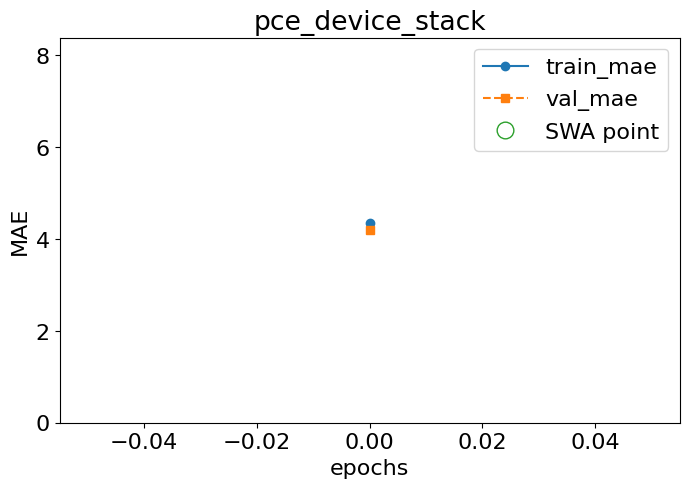

Epoch: 19/300 --- train mae: 2.19 val mae: 2.52


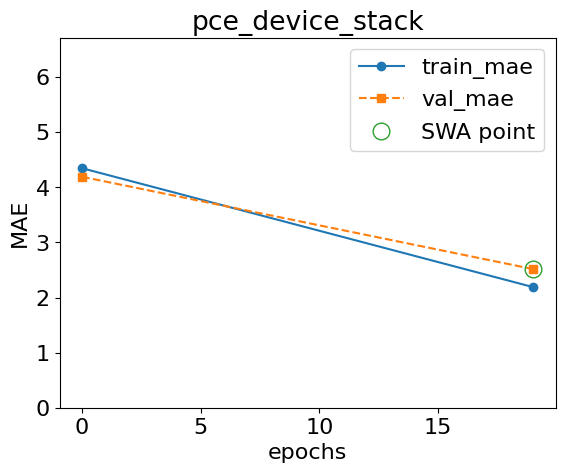

Epoch: 39/300 --- train mae: 1.91 val mae: 2.31


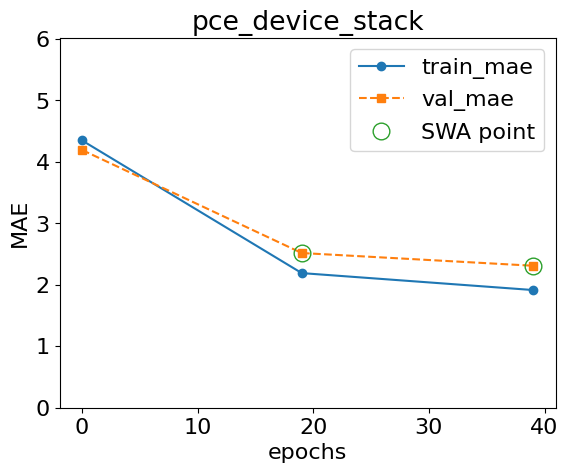

Epoch: 59/300 --- train mae: 1.82 val mae: 2.28


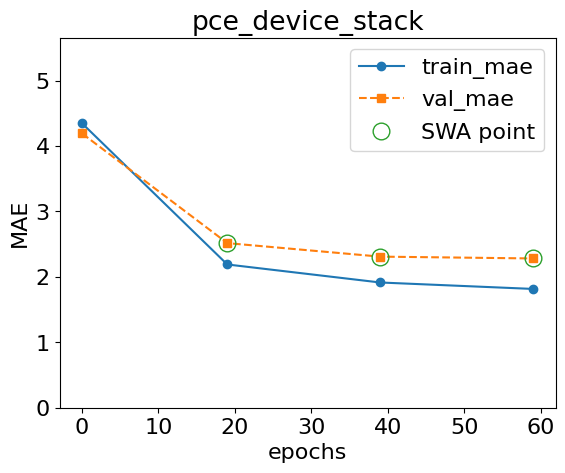

Epoch 79 failed to improve.
Discarded: 1/3 weight updates
Epoch: 79/300 --- train mae: 1.74 val mae: 2.33


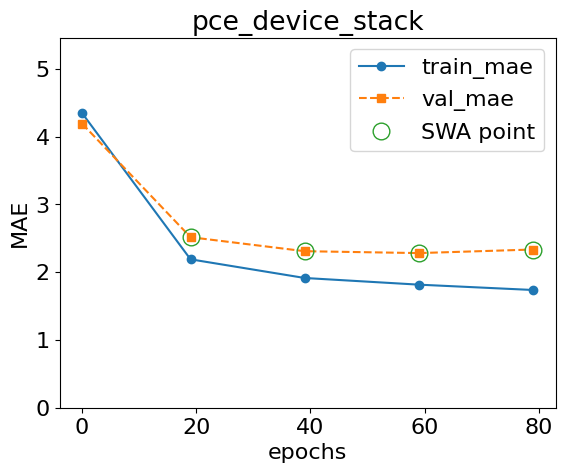

Epoch: 99/300 --- train mae: 1.7 val mae: 2.22


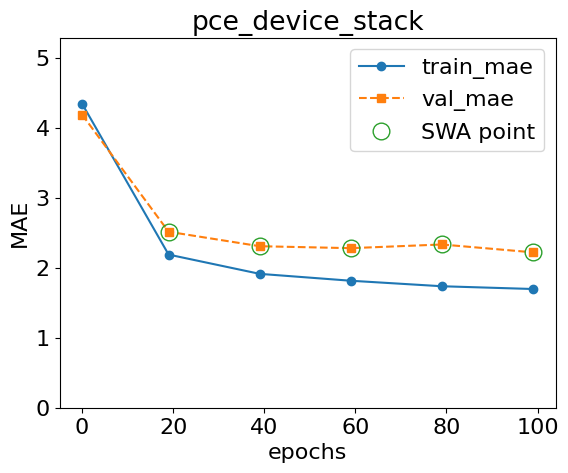

Epoch 119 failed to improve.
Discarded: 2/3 weight updates
Epoch: 119/300 --- train mae: 1.67 val mae: 2.26


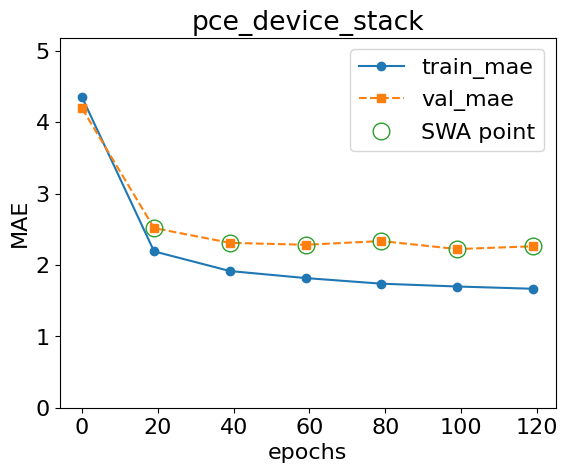

Epoch 139 failed to improve.
Discarded: 3/3 weight updates
Epoch: 139/300 --- train mae: 1.67 val mae: 2.26


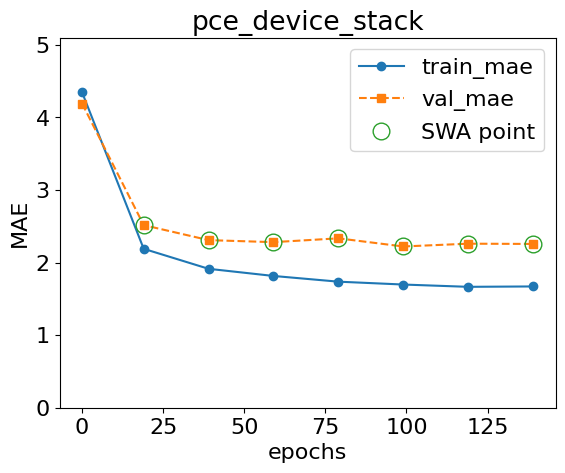

Discarded: 3/3weight updates, early-stopping now
Saving network (pce_device_stack) to models\trained_models\pce_device_stack.pth


In [13]:
# cb = CrabNet(
#     mat_prop="pce",
#     train_df=train_df, # contains "formula", "target", and "state_var0" columns
#     extend_features=['device_stack_encoded', 'etl_encoded', 'htl_encoded'],
#     )
from crabnet.crabnet_ import CrabNet
cb_pce = CrabNet(mat_prop="pce", model_name='pce_device_stack', elem_prop='mat2vec', learningcurve=False, extend_features=['device_stack_encoded', 'etl_encoded', 'htl_encoded'])
cb_pce.fit(train_df, val_df)

In [47]:
!pip install torch

  Using cached filelock-3.14.0-py3-none-any.whl.metadata (2.8 kB)
  Using cached mkl-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.4 kB)
  Using cached intel_openmp-2021.4.0-py2.py3-none-win_amd64.whl.metadata (1.2 kB)
  Using cached tbb-2021.12.0-py3-none-win_amd64.whl.metadata (1.1 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/159.7 MB ? eta -:--:--
   ---------------------------------------- 0.2/159.7 MB 1.5 MB/s eta 0:01:45
   ---------------------------------------- 0.2/159.7 MB 1.5 MB/s eta 0:01:45
   ---------------------------------------- 0.3/159.7 MB 1.2 MB/s eta 0:02:10
   ---------------------------------------- 0.5/159.7 MB 1.4 MB/s eta 0:01:52
   ---------------------------------------- 0.6/159.7 MB 1.3 MB/s eta 0:02:00
   ---------------------------------------- 0.6/159.7 MB 1.3 MB/s eta 0:02:04
   ---------------------------------------- 0.7/159.7 MB 1.3 MB/s eta 0:02:04
   --------------------------

In [14]:
import pickle
with open('pickles/initial_pce_model.pkl', 'wb') as f:
    pickle.dump(cb_pce, f)

# prediction

In [15]:
from crabnet.utils.figures import act_pred
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

Generating EDM: 100%|██████████| 947/947 [00:00<00:00, 17900.79formulae/s]


loading data with up to 8 elements in the formula


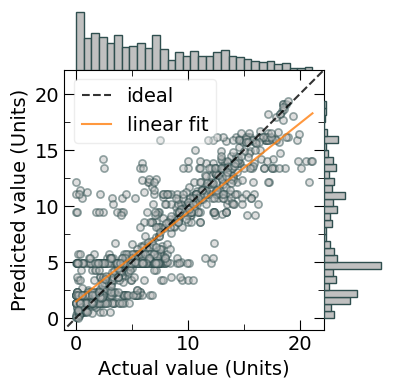

R2 score: 0.7693531836617483
MSE: 6.376912579714013
MAE: 1.698343729582271 %


In [16]:
# Training accuracy
# replcae with zeros to predict the target value
train_df_zeros = pd.DataFrame(({
    "formula": train_df['formula'],
    "target": [0.0]*len(train_df['formula']),
    "device_stack_encoded": train_df['device_stack_encoded'],
    "device_stack": train_df['device_stack'],
    "etl": train_df['etl'],
    "etl_encoded": train_df['etl_encoded'],
    "htl": train_df['htl'],
    "htl_encoded": train_df['htl_encoded']}))
train_df_predicted, train_df_predicted_sigma = cb_pce.predict(train_df_zeros, return_uncertainty=True)

act_pred(train_df['target'], train_df_predicted)
r2 = r2_score(train_df['target'], train_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(train_df['target'], train_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(train_df['target'], train_df_predicted)
print(f'MAE: {mae} %')

Generating EDM: 100%|██████████| 118/118 [00:00<00:00, 16856.64formulae/s]


loading data with up to 8 elements in the formula


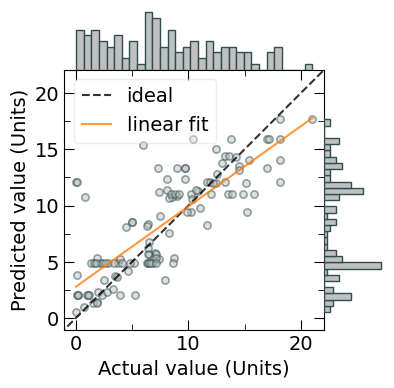

R2 score: 0.6333971672221407
MSE: 9.62673857177779
MAE: 2.2215656818777827 %


In [17]:
# Validation accuracy
# replcae with zeros to predict the target value
val_df_zeros = pd.DataFrame(({
    "formula": val_df['formula'],
    "target": [0.0]*len(val_df['formula']),
    "device_stack_encoded": val_df['device_stack_encoded'],
    "device_stack": val_df['device_stack'],
    "etl": val_df['etl'],
    "etl_encoded": val_df['etl_encoded'],
    "htl": val_df['htl'],
    "htl_encoded": val_df['htl_encoded']}))
val_df_predicted, val_df_predicted_sigma = cb_pce.predict(val_df_zeros, return_uncertainty=True)

act_pred(val_df['target'], val_df_predicted)
r2 = r2_score(val_df['target'], val_df_predicted)
print(f'R2 score: {r2}')
mse = mean_squared_error(val_df['target'], val_df_predicted)
print(f'MSE: {mse}')
mae = mean_absolute_error(val_df['target'], val_df_predicted)
print(f'MAE: {mae} %')